In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import mlab
from scipy import signal
import h5py, time
import sys
import glob
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
from tqdm import tqdm


In [29]:
def get_force_from_discharge(folder,file_list,axis,drive_freq=151):
    ret_value = []
    for i in file_list:
        fname = folder+"/Bead"+str(BeadNumber)+"/Discharge"+"/Discharge_%d.h5" %i
        BDF = BeadDataFile.BeadDataFile(fname)
        data = BDF.xyz2
        fsamp=5000
        res=50000
        data_det=signal.detrend(data)     
        xpsd, freqs = matplotlib.mlab.psd(data_det[0], Fs = fsamp, NFFT = res,window=mlab.window_none)
        ypsd, freqs = matplotlib.mlab.psd(data_det[1], Fs = fsamp, NFFT = res,window=mlab.window_none)
        zpsd, freqs = matplotlib.mlab.psd(data_det[2], Fs = fsamp, NFFT = res,window=mlab.window_none)
        if(str(axis)=="x"):
            ret_value.append(np.sqrt(xpsd[drive_freq*10]))
        if(str(axis)=="y"):
            ret_value.append(np.sqrt(ypsd[drive_freq*10]))
        if(str(axis)=="z"):
            ret_value.append(np.sqrt(zpsd[drive_freq*10]))
    return ret_value

def force_conversion_factor(q,V=10,conv_factor=0.65,electrode_distance=8.6e-3):
    F=(q*1.602e-19)*(V*2/electrode_distance*conv_factor)
    return F 


def bit_to_force_conversion_factor(file_list,axis,q,V=10):
    bit_normal = np.mean(get_force_from_discharge(folder,file_list,axis))
    force=force_conversion_factor(q,V)
    bit_to_force = force/bit_normal
    return bit_to_force

In [30]:
# Force calibration using transfer function

def transfer_func_prep(folder,axis,base_freq=7):
    # get the file name with the convention Akio has chosen
    res=50000
    fsamp= 5000
    if(axis=="X"):
        x_list =[]
        number = 1
        fname = folder+"/Bead"+str(BeadNumber)+"/TransFunc"+"/Transfunc%s_%d.h5" %(axis,number)
        BDF = BeadDataFile.BeadDataFile(fname)
        data = BDF.xyz2
        data_det=signal.detrend(data)
        Xpsd, freqs = matplotlib.mlab.psd(data_det[0], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Ypsd, freqs = matplotlib.mlab.psd(data_det[1], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Zpsd, freqs = matplotlib.mlab.psd(data_det[2], Fs = fsamp, NFFT = res,window=mlab.window_none)
        
        x_list.append(np.sqrt(Xpsd[base_freq*10])) 
        x_list.append(np.sqrt(Xpsd)) 
        x_list.append(np.sqrt(Ypsd)) 
        x_list.append(np.sqrt(Zpsd))
        #print("Returning list with Noise at base frequency,XNoise,YNoise,ZNoise")
        return x_list
    if(axis=="Y"):
        y_list =[]
        number = 2
        fname = folder+"/Bead"+str(BeadNumber)+"/TransFunc"+"/Transfunc%s_%d.h5" %(axis,number)
        BDF = BeadDataFile.BeadDataFile(fname)
        data = BDF.xyz2
        data_det=signal.detrend(data)
        Xpsd, freqs = matplotlib.mlab.psd(data_det[0], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Ypsd, freqs = matplotlib.mlab.psd(data_det[1], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Zpsd, freqs = matplotlib.mlab.psd(data_det[2], Fs = fsamp, NFFT = res,window=mlab.window_none)
        y_list.append(np.sqrt(Ypsd[base_freq*10])) 
        y_list.append(np.sqrt(Xpsd)) 
        y_list.append(np.sqrt(Ypsd)) 
        y_list.append(np.sqrt(Zpsd))
        #print("Returning list with Noise at base frequency,XNoise,YNoise,ZNoise")
        return y_list
    if(axis=="Z"):
        z_list =[]
        number = 3
        fname = folder+"/Bead"+str(BeadNumber)+"/TransFunc"+"/Transfunc%s_%d.h5" %(axis,number)
        BDF = BeadDataFile.BeadDataFile(fname)
        data = BDF.xyz2
        data_det=signal.detrend(data)
        Xpsd, freqs = matplotlib.mlab.psd(data_det[0], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Ypsd, freqs = matplotlib.mlab.psd(data_det[1], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Zpsd, freqs = matplotlib.mlab.psd(data_det[2], Fs = fsamp, NFFT = res,window=mlab.window_none)
        z_list.append(np.sqrt(Zpsd[base_freq*10])) 
        z_list.append(np.sqrt(Xpsd)) 
        z_list.append(np.sqrt(Ypsd)) 
        z_list.append(np.sqrt(Zpsd))
        #print("Returning list with Noise at base frequency,XNoise,YNoise,ZNoise")
        return z_list


In [31]:
def transfer_func_output(folder,q,V,base_freq=7,no_harmonics=100):
    x_list = transfer_func_prep(folder,"X",base_freq=base_freq)
    y_list = transfer_func_prep(folder,"Y",base_freq=base_freq)
    z_list = transfer_func_prep(folder,"Z",base_freq=base_freq)
    F = force_conversion_factor(q,V)
    
    force_noise_in_x = []
    force_noise_in_x.append(x_list[1]/x_list[0]*F)
    force_noise_in_x.append(x_list[2]/y_list[0]*F)
    force_noise_in_x.append(x_list[3]/z_list[0]*F)
    force_noise_in_y = []
    force_noise_in_y.append(y_list[1]/x_list[0]*F)
    force_noise_in_y.append(y_list[2]/y_list[0]*F)
    force_noise_in_y.append(y_list[3]/z_list[0]*F)  
    force_noise_in_z = []
    force_noise_in_z.append(z_list[1]/x_list[0]*F)
    force_noise_in_z.append(z_list[2]/y_list[0]*F)
    force_noise_in_z.append(z_list[3]/z_list[0]*F)   
    
    TFXX=[]
    TFXY=[]
    TFXZ=[]
    TFYX=[]
    TFYY=[]
    TFYZ=[]
    TFZX=[]
    TFZY=[]
    TFZZ=[]
    
    FreqTF = np.arange(base_freq,(base_freq*no_harmonics+base_freq),base_freq)
    for i in range(no_harmonics):
        TFXX.append(force_noise_in_x[0][base_freq*10*(i+1)])
        TFXY.append(force_noise_in_x[1][base_freq*10*(i+1)])
        TFXZ.append(force_noise_in_x[2][base_freq*10*(i+1)])
        TFYX.append(force_noise_in_y[0][base_freq*10*(i+1)])
        TFYY.append(force_noise_in_y[1][base_freq*10*(i+1)])
        TFYZ.append(force_noise_in_y[2][base_freq*10*(i+1)])
        TFZX.append(force_noise_in_z[0][base_freq*10*(i+1)])
        TFZY.append(force_noise_in_z[1][base_freq*10*(i+1)])
        TFZZ.append(force_noise_in_z[2][base_freq*10*(i+1)])
                    
    TFX = [TFXX,TFXY,TFXZ]
    TFY = [TFYX,TFYY,TFYZ]
    TFZ = [TFZX,TFZY,TFZZ]
    TF = [TFX,TFY,TFZ]                
    return FreqTF,TF    

In [32]:
def transfer_function1(data_x,params=list):
    # for normalization a 1/sigma could be needed
    return params[0]*params[1]**2/np.sqrt((data_x*data_x-params[1]**2)**2+params[2]**2*data_x**2)+params[3]

def chisquare_1d(function, data_x, data_y,data_y_error, functionparams=list):
    chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
    ndf = len(data_y)-len(functionparams)
    #print(ndf)
    return (chisquarevalue, ndf)

def chisquare_tf(a,b,c,d):
    return chisquare_1d(function=transfer_function1,functionparams=[a,b,c,d],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def two_dimensional_gaussian(data_x,data_y,params=list):
    #g1 = ((data_x-params[1])/params[2]);
    #g2 = ((data_x-params[2])/params[4]);   
    return params[0]*np.exp(-0.5*(np.power((((data_x-params[1])*np.cos(params[3])-(data_y-params[2])*np.sin(params[3]))/params[4]),2)+np.power((((data_x-params[1])*np.sin(params[3])+(data_y-params[2])*np.cos(params[3]))/params[5]),2)))+params[6]
              


In [33]:
def transfer_function_fits(FreqTF,TF,fix_d=False,base_freq=7):
    parameter_list = []
    for i in np.arange(0,3,1):
        def chisquare_tf(a,b,c,d):
            return chisquare_1d(function=transfer_function1,functionparams=[a,b,c,d],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
        data_x = np.asarray(FreqTF)
        data_y=np.asarray(TF[i][i])
        data_y_error=data_y/10
        m2=Minuit(chisquare_tf,a=1e-16,fix_a=False,b=415,fix_b=False,c=2,fix_c=False,d=0,fix_d=fix_d,errordef = 1,print_level=1)
        m2.migrad(ncall=500000)
        var_list=[m2.values["a"],m2.values["b"],m2.values["c"],m2.values["d"]]
        parameter_list.append(var_list)
        plt.title("%s" %i)
        plt.plot(FreqTF,transfer_function1(data_x,params=[m2.values["a"],m2.values["b"],m2.values["c"],m2.values["d"]]))
        plt.plot(FreqTF,TF[i][i])
        plt.yscale("log")
        plt.show()
    return parameter_list    

In [47]:
def from_data_to_force_amp_and_phase_per_harmonic(folder,data_set_list,file_list,q,V=10,shake_freq=13,no_harmonics=100,drive_freq=151,base_freq=7,no_harmonics_tf=100):
        FreqTF,TF = transfer_func_output(folder,q,V,no_harmonics=no_harmonics_tf)
        TF_val = transfer_function_fits(FreqTF,TF)
        file_amp_list = []
        file_phase_list = []
        for data_set in tqdm(data_set_list):
            fname = data_set#folder+"/Bead"+str(BeadNumber)+"/Shaking"+"/Shaking%d_%d.h5" % (data_set,0)
            BDF = BeadDataFile.BeadDataFile(fname)
            data = BDF.xyz2
            res = 50000
            fsamp=5000
            data_det=signal.detrend(data)
            freqs=np.linspace(0,2500,(res/2)+1)    # change
            xFFT=np.fft.rfft(data_det[0])
            yFFT=np.fft.rfft(data_det[1])
            zFFT=np.fft.rfft(data_det[2])
            norm = np.sqrt(2 / (res* fsamp))
            xpsd = norm**2 * (xFFT * xFFT.conj()).real
            ypsd = norm**2 * (yFFT * yFFT.conj()).real
            zpsd = norm**2 * (zFFT * zFFT.conj()).real

            w0x=TF_val[0][1]
            gx=TF_val[0][2]
            w0y=TF_val[1][1]
            gy=TF_val[1][2]
            w0z=TF_val[2][1]
            gz=TF_val[2][2]
            BtoFx=bit_to_force_conversion_factor(file_list[0],"x",q,V)#3.14E-12
            BtoFy=bit_to_force_conversion_factor(file_list[1],"y",q,V)#1.57E-12
            BtoFz=bit_to_force_conversion_factor(file_list[2],"z",q,V)#2.71E-19
            const_x = TF_val[0][3]
            const_y = TF_val[1][3]
            const_z = TF_val[2][3]

            f0=drive_freq
            F0x=1/(np.sqrt((f0**2-w0x**2)**2+gx**2*f0**2)+const_x)
            F0y=1/(np.sqrt((f0**2-w0y**2)**2+gy**2*f0**2)+const_y)
            F0z=1/(np.sqrt((f0**2-w0z**2)**2+gz**2*f0**2)+const_z)

            xnsd=np.sqrt(xpsd)*BtoFx*F0x*(np.sqrt((freqs**2-w0x**2)**2+gx**2*freqs**2)+const_x)
            ynsd=np.sqrt(ypsd)*BtoFy*F0y*(np.sqrt((freqs**2-w0y**2)**2+gy**2*freqs**2)+const_y)
            znsd=np.sqrt(zpsd)*BtoFz*F0z*(np.sqrt((f0**2-w0z**2)**2+gz**2*f0**2)+const_z)

            xphase=np.angle(xFFT)
            yphase=np.angle(yFFT)
            zphase=np.angle(zFFT)

            # now get amplitude and phase from all harmonics

            no_harmonics=np.arange(1,100,1)
            norm_factor = 10
            frequency=13
            response_amp=[]
            response_phase = []
            for i in no_harmonics:
                a = xnsd[i*shake_freq*norm_factor] * np.cos(xphase[i*shake_freq*norm_factor]) 
                b = xnsd[i*shake_freq*norm_factor] * np.sin(xphase[i*shake_freq*norm_factor])
                response_amp.append(a)
                response_phase.append(b)
            file_amp_list.append(response_amp)
            file_phase_list.append(response_phase)
        return file_amp_list,file_phase_list
        

In [48]:
#discharge file_lists
file_list = []
x_discharge_files = range(42,46)
file_list.append(x_discharge_files)
y_discharge_files = range(47,51)
file_list.append(y_discharge_files)
z_discharge_files = range(52,56)
file_list.append(z_discharge_files)

Year = "2019"
Month = "11"
Day = "14"
BeadNumber =1
folder = r"/home/data_transfer/data_from_windows/"+ Year + Month + Day

In [36]:
# prepare the background files, for the 10e9 simulation

files = glob.glob(folder+"/Bead"+str(BeadNumber)+"/Shaking/Shaking24/Shaking*")
files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

No cantilever data
Error loading spinning data
No cantilever data
Error loading spinning data
No cantilever data
Error loading spinning data
------------------------------------------------------------------
| FCN = 1478                    |     Ncalls=228 (228 total)     |
| EDM = 6.51E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------


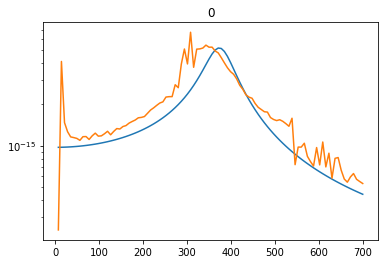

------------------------------------------------------------------
| FCN = 1016                    |     Ncalls=360 (360 total)     |
| EDM = 1.8E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------


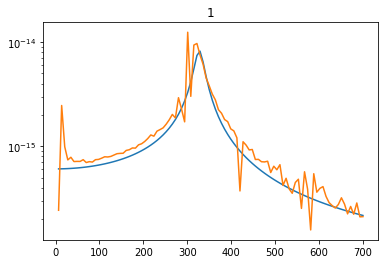

------------------------------------------------------------------
| FCN = 1261                    |     Ncalls=343 (343 total)     |
| EDM = 3.56E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------


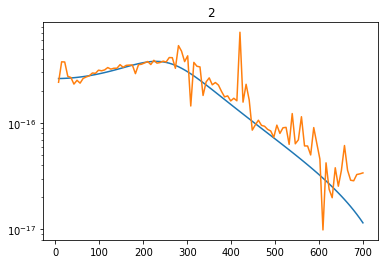




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:00<14:27,  1.15it/s]


  0%|          | 2/1000 [00:01<14:48,  1.12it/s]


  0%|          | 3/1000 [00:02<14:37,  1.14it/s]


  0%|          | 4/1000 [00:03<14:25,  1.15it/s]


  0%|          | 5/1000 [00:04<14:15,  1.16it/s]


  1%|          | 6/1000 [00:05<14:10,  1.17it/s]


  1%|          | 7/1000 [00:06<14:09,  1.17it/s]


  1%|          | 8/1000 [00:06<13:58,  1.18it/s]


  1%|          | 9/1000 [00:07<14:48,  1.12it/s]


  1%|          | 10/1000 [00:09<16:14,  1.02it/s]


  1%|          | 11/1000 [00:10<17:01,  1.03s/it]


  1%|          | 12/1000 [00:11<17:43,  1.08s/it]


  1%|▏         | 13/1000 [00:13<20:39,  1.26s/it]


  1%|▏         | 14/1000 [00:14<21:24,  1.30s/it]


  2%|▏         | 15/1000 [00:15<20:38,  1.26s/it]


  2%|▏         | 16/1000 [00:16<18:47,  1.15s/it]


  2%|▏         | 17/1000 [00:17<17:27,  1.07s/it]


  2%|▏         | 18/1000 [00:18<16:32,  1.01s/it]


  2%|▏         | 19/1000 [0

 13%|█▎        | 134/1000 [02:14<19:28,  1.35s/it]


 14%|█▎        | 135/1000 [02:15<18:58,  1.32s/it]


 14%|█▎        | 136/1000 [02:16<17:30,  1.22s/it]


 14%|█▎        | 137/1000 [02:17<16:21,  1.14s/it]


 14%|█▍        | 138/1000 [02:18<15:33,  1.08s/it]


 14%|█▍        | 139/1000 [02:19<15:08,  1.06s/it]


 14%|█▍        | 140/1000 [02:20<15:02,  1.05s/it]


 14%|█▍        | 141/1000 [02:21<14:29,  1.01s/it]


 14%|█▍        | 142/1000 [02:22<14:04,  1.02it/s]


 14%|█▍        | 143/1000 [02:23<13:53,  1.03it/s]


 14%|█▍        | 144/1000 [02:24<13:28,  1.06it/s]


 14%|█▍        | 145/1000 [02:25<13:10,  1.08it/s]


 15%|█▍        | 146/1000 [02:26<13:11,  1.08it/s]


 15%|█▍        | 147/1000 [02:27<13:02,  1.09it/s]


 15%|█▍        | 148/1000 [02:28<13:08,  1.08it/s]


 15%|█▍        | 149/1000 [02:29<12:57,  1.09it/s]


 15%|█▌        | 150/1000 [02:29<12:48,  1.11it/s]


 15%|█▌        | 151/1000 [02:30<12:53,  1.10it/s]


 15%|█▌        | 152/1000 [02:31<12:48,  1.10i

 27%|██▋       | 266/1000 [04:21<12:47,  1.05s/it]


 27%|██▋       | 267/1000 [04:22<12:13,  1.00s/it]


 27%|██▋       | 268/1000 [04:23<11:47,  1.03it/s]


 27%|██▋       | 269/1000 [04:23<11:30,  1.06it/s]


 27%|██▋       | 270/1000 [04:24<11:25,  1.06it/s]


 27%|██▋       | 271/1000 [04:25<11:16,  1.08it/s]


 27%|██▋       | 272/1000 [04:26<11:15,  1.08it/s]


 27%|██▋       | 273/1000 [04:27<11:04,  1.09it/s]


 27%|██▋       | 274/1000 [04:28<10:58,  1.10it/s]


 28%|██▊       | 275/1000 [04:29<11:04,  1.09it/s]


 28%|██▊       | 276/1000 [04:30<11:05,  1.09it/s]


 28%|██▊       | 277/1000 [04:31<10:55,  1.10it/s]


 28%|██▊       | 278/1000 [04:32<10:53,  1.11it/s]


 28%|██▊       | 279/1000 [04:33<10:54,  1.10it/s]


 28%|██▊       | 280/1000 [04:33<10:54,  1.10it/s]


 28%|██▊       | 281/1000 [04:34<10:47,  1.11it/s]


 28%|██▊       | 282/1000 [04:35<10:38,  1.12it/s]


 28%|██▊       | 283/1000 [04:36<10:41,  1.12it/s]


 28%|██▊       | 284/1000 [04:37<10:36,  1.13i

 40%|███▉      | 398/1000 [06:26<09:04,  1.10it/s]


 40%|███▉      | 399/1000 [06:27<09:07,  1.10it/s]


 40%|████      | 400/1000 [06:27<09:06,  1.10it/s]


 40%|████      | 401/1000 [06:28<09:07,  1.09it/s]


 40%|████      | 402/1000 [06:29<09:02,  1.10it/s]


 40%|████      | 403/1000 [06:30<08:57,  1.11it/s]


 40%|████      | 404/1000 [06:31<08:56,  1.11it/s]


 40%|████      | 405/1000 [06:32<09:07,  1.09it/s]


 41%|████      | 406/1000 [06:33<09:13,  1.07it/s]


 41%|████      | 407/1000 [06:34<09:09,  1.08it/s]


 41%|████      | 408/1000 [06:35<09:02,  1.09it/s]


 41%|████      | 409/1000 [06:36<08:57,  1.10it/s]


 41%|████      | 410/1000 [06:37<09:00,  1.09it/s]


 41%|████      | 411/1000 [06:38<08:57,  1.10it/s]


 41%|████      | 412/1000 [06:38<08:54,  1.10it/s]


 41%|████▏     | 413/1000 [06:39<09:01,  1.08it/s]


 41%|████▏     | 414/1000 [06:40<08:51,  1.10it/s]


 42%|████▏     | 415/1000 [06:41<08:59,  1.08it/s]


 42%|████▏     | 416/1000 [06:42<08:54,  1.09i

 53%|█████▎    | 530/1000 [08:33<07:31,  1.04it/s]


 53%|█████▎    | 531/1000 [08:34<07:32,  1.04it/s]


 53%|█████▎    | 532/1000 [08:35<07:22,  1.06it/s]


 53%|█████▎    | 533/1000 [08:36<07:19,  1.06it/s]


 53%|█████▎    | 534/1000 [08:37<07:17,  1.06it/s]


 54%|█████▎    | 535/1000 [08:38<07:30,  1.03it/s]


 54%|█████▎    | 536/1000 [08:39<07:29,  1.03it/s]


 54%|█████▎    | 537/1000 [08:40<07:31,  1.03it/s]


 54%|█████▍    | 538/1000 [08:41<07:29,  1.03it/s]


 54%|█████▍    | 539/1000 [08:42<07:32,  1.02it/s]


 54%|█████▍    | 540/1000 [08:43<07:29,  1.02it/s]


 54%|█████▍    | 541/1000 [08:44<07:21,  1.04it/s]


 54%|█████▍    | 542/1000 [08:45<07:23,  1.03it/s]


 54%|█████▍    | 543/1000 [08:46<07:21,  1.03it/s]


 54%|█████▍    | 544/1000 [08:47<07:16,  1.04it/s]


 55%|█████▍    | 545/1000 [08:48<07:18,  1.04it/s]


 55%|█████▍    | 546/1000 [08:49<07:22,  1.03it/s]


 55%|█████▍    | 547/1000 [08:50<07:19,  1.03it/s]


 55%|█████▍    | 548/1000 [08:51<07:15,  1.04i

 66%|██████▌   | 662/1000 [10:44<05:18,  1.06it/s]


 66%|██████▋   | 663/1000 [10:45<05:12,  1.08it/s]


 66%|██████▋   | 664/1000 [10:46<05:08,  1.09it/s]


 66%|██████▋   | 665/1000 [10:47<05:06,  1.09it/s]


 67%|██████▋   | 666/1000 [10:48<04:59,  1.12it/s]


 67%|██████▋   | 667/1000 [10:49<04:57,  1.12it/s]


 67%|██████▋   | 668/1000 [10:50<04:59,  1.11it/s]


 67%|██████▋   | 669/1000 [10:51<05:03,  1.09it/s]


 67%|██████▋   | 670/1000 [10:52<05:04,  1.08it/s]


 67%|██████▋   | 671/1000 [10:53<05:06,  1.07it/s]


 67%|██████▋   | 672/1000 [10:53<05:02,  1.08it/s]


 67%|██████▋   | 673/1000 [10:54<05:03,  1.08it/s]


 67%|██████▋   | 674/1000 [10:55<05:00,  1.09it/s]


 68%|██████▊   | 675/1000 [10:56<04:56,  1.10it/s]


 68%|██████▊   | 676/1000 [10:57<04:53,  1.10it/s]


 68%|██████▊   | 677/1000 [10:58<05:08,  1.05it/s]


 68%|██████▊   | 678/1000 [10:59<05:06,  1.05it/s]


 68%|██████▊   | 679/1000 [11:00<05:03,  1.06it/s]


 68%|██████▊   | 680/1000 [11:01<05:00,  1.07i

 79%|███████▉  | 794/1000 [12:51<03:04,  1.12it/s]


 80%|███████▉  | 795/1000 [12:52<03:02,  1.12it/s]


 80%|███████▉  | 796/1000 [12:53<03:02,  1.12it/s]


 80%|███████▉  | 797/1000 [12:54<03:00,  1.12it/s]


 80%|███████▉  | 798/1000 [12:55<02:58,  1.13it/s]


 80%|███████▉  | 799/1000 [12:56<02:59,  1.12it/s]


 80%|████████  | 800/1000 [12:57<03:00,  1.11it/s]


 80%|████████  | 801/1000 [12:57<02:59,  1.11it/s]


 80%|████████  | 802/1000 [12:58<02:58,  1.11it/s]


 80%|████████  | 803/1000 [12:59<02:55,  1.12it/s]


 80%|████████  | 804/1000 [13:00<02:55,  1.11it/s]


 80%|████████  | 805/1000 [13:01<02:54,  1.12it/s]


 81%|████████  | 806/1000 [13:02<02:55,  1.11it/s]


 81%|████████  | 807/1000 [13:03<02:55,  1.10it/s]


 81%|████████  | 808/1000 [13:04<02:55,  1.09it/s]


 81%|████████  | 809/1000 [13:05<02:56,  1.08it/s]


 81%|████████  | 810/1000 [13:06<02:53,  1.09it/s]


 81%|████████  | 811/1000 [13:07<02:53,  1.09it/s]


 81%|████████  | 812/1000 [13:08<03:04,  1.02i

 93%|█████████▎| 926/1000 [15:11<01:35,  1.29s/it]


 93%|█████████▎| 927/1000 [15:12<01:33,  1.28s/it]


 93%|█████████▎| 928/1000 [15:13<01:34,  1.32s/it]


 93%|█████████▎| 929/1000 [15:15<01:32,  1.30s/it]


 93%|█████████▎| 930/1000 [15:16<01:25,  1.22s/it]


 93%|█████████▎| 931/1000 [15:17<01:18,  1.14s/it]


 93%|█████████▎| 932/1000 [15:18<01:12,  1.07s/it]


 93%|█████████▎| 933/1000 [15:19<01:09,  1.04s/it]


 93%|█████████▎| 934/1000 [15:19<01:05,  1.00it/s]


 94%|█████████▎| 935/1000 [15:20<01:04,  1.01it/s]


 94%|█████████▎| 936/1000 [15:21<01:01,  1.03it/s]


 94%|█████████▎| 937/1000 [15:22<01:00,  1.05it/s]


 94%|█████████▍| 938/1000 [15:23<00:57,  1.08it/s]


 94%|█████████▍| 939/1000 [15:24<00:55,  1.10it/s]


 94%|█████████▍| 940/1000 [15:25<00:54,  1.10it/s]


 94%|█████████▍| 941/1000 [15:26<00:54,  1.08it/s]


 94%|█████████▍| 942/1000 [15:27<00:53,  1.08it/s]


 94%|█████████▍| 943/1000 [15:28<00:52,  1.09it/s]


 94%|█████████▍| 944/1000 [15:29<00:51,  1.10i

In [37]:
amp,phase = from_data_to_force_amp_and_phase_per_harmonic(folder=folder,data_set_list=files[0:1000],file_list=file_list,q=1,V=10,shake_freq=13,no_harmonics=100,drive_freq=151,base_freq=7,no_harmonics_tf=100)


In [49]:
scale_factor_for_fit = 1/1e-16
amp_swap = np.swapaxes(amp,0,1,)*scale_factor_for_fit
phase_swap = np.swapaxes(phase,0,1)*scale_factor_for_fit
z, xedges,yedges = np.histogram2d(amp_swap[4],phase_swap[4],bins=(10,10))

In [39]:
print(np.mean(amp_swap[0]))

0.0041167995491775584


In [40]:
x_bin_center = 0.5*(xedges[1:]+xedges[:-1])
y_bin_center = 0.5*(yedges[1:]+yedges[:-1])

x_mesh, y_mesh = np.meshgrid(x_bin_center, y_bin_center)
x_mesh_ravel = x_mesh.ravel()
y_mesh_ravel = y_mesh.ravel()

data_z_ravel = z.ravel()
z_error = np.sqrt(data_z_ravel)

No handles with labels found to put in legend.


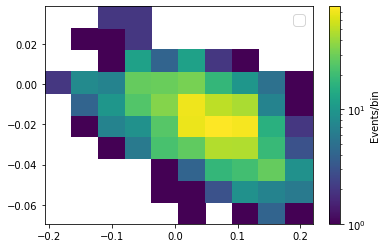

In [41]:
plot_bins = 256
xplot = np.linspace(amp[0],amp[-1],plot_bins)
yplot= np.linspace(phase[0],phase[-1],plot_bins)

xplot,yplot = np.meshgrid(xplot,yplot)


fig, ax = plt.subplots(1, 1)

plt.pcolormesh(xedges, yedges, z, norm = matplotlib.colors.LogNorm())

plt.colorbar(label = "Events/bin")
#plt.xlabel('$cs1$ [pe]')
#plt.ylabel('$cs2_b/100$ [pe]')


plt.legend(fancybox=True, fontsize = 15)

In [42]:
def two_dimensional_gaussian_XENONStyle(data_x,data_y,params=list):
    g1 = np.power((((data_x-params[1])*np.cos(params[3])-(data_y-params[2])*np.sin(params[3]))/params[4]),2)
    g2 = np.power((((data_x-params[1])*np.sin(params[3])+(data_y-params[2])*np.cos(params[3]))/params[5]),2)
    #g2 = ((data_x-params[2])/params[4]);   
    return params[0]*np.exp(-0.5*(g1+g2))+params[6]
 
    
def two_dimensional_gaussian_Akiostyle(data_x,data_y,params=list):
    g1 = ((data_x-params[1])/params[2])
    g2 = ((data_x-params[3])/params[4])
    return params[0]*np.exp(-0.5*(g1**2+g2**2))

# checked both, equivalent, but akios are formulated in a convolved parameter way

In [43]:
def chisquare_2d(function, data_x, data_y,data_z,data_z_error, functionparams=list):
    chisquarevaluex=np.sum(np.power(np.divide(np.subtract(function(data_x,data_y,functionparams),data_z),data_z_error),2))
    ndf = len(data_y)-len(functionparams)
    #print(ndf)
    return (chisquarevaluex, ndf)

def chisquare_2d_gaus_xenon(amp,x0,y0,theta,a,b,const):
    return chisquare_2d(function=two_dimensional_gaussian_XENONStyle,functionparams=[amp,x0,y0,theta,a,b,const],data_x=data_x,data_y=data_y,data_z=data_z,data_z_error=data_z_error)[0]

def chisquare_2d_gaus_Akio(a,b,c,d,e,f):
    return chisquare_2d(function=two_dimensional_gaussian_Akiostyle,functionparams=[a,b,c,d,e,f],data_x=data_x,data_y=data_y,data_z=data_z,data_z_error=data_z_error)[0]


In [44]:
data_x = x_mesh_ravel
data_y = y_mesh_ravel
data_z = data_z_ravel
data_z_error = np.sqrt(data_z) + 1
m2=Minuit(chisquare_2d_gaus_xenon,amp=10,fix_amp=False,x0=1,fix_x0=False,y0=1,fix_y0=False,theta=0.1,a=1,b=1,const=0,errordef = 1,print_level=1)
m2.migrad(ncall=500000)
print(m2.values["amp"],m2.values["x0"]/scale_factor_for_fit,m2.values["y0"]/scale_factor_for_fit,m2.values["theta"],m2.values["a"],m2.values["b"],m2.values["const"])
print()
#plt.title("%s" %i)
#plt.plot(FreqTF,transfer_function1(data_x,params=[m2.values["a"],m2.values["b"],m2.values["c"],m2.values["d"]]))
#plt.plot(FreqTF,TF[i][i])
#plt.yscale("log")
#plt.show()

------------------------------------------------------------------
| FCN = 66.53                   |    Ncalls=2230 (2230 total)    |
| EDM = 3.94E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
79.82223171529674 5.587996038469797e-18 -1.8821631540227628e-18 1.6854303489663784 0.012422099775652512 0.0669968128487227 0.021056936819692906



/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
  """


No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'label'


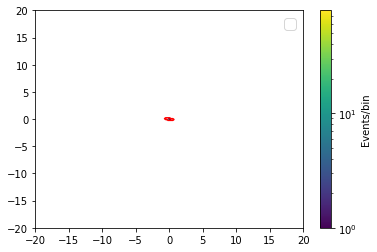

In [45]:
arg_list = [m2.values["amp"],m2.values["x0"],m2.values["y0"],m2.values["theta"],m2.values["a"],m2.values["b"],m2.values["const"]]

plot_bins = 256
xplot = np.linspace(-20,20,plot_bins)
yplot= np.linspace(-20,20,plot_bins)

xplot,yplot = np.meshgrid(xplot,yplot)

fig, ax = plt.subplots(1, 1)

plt.pcolormesh(xedges, yedges, z, norm = matplotlib.colors.LogNorm(), cmap="viridis")
plt.colorbar(label = "Events/bin")
plt.legend(fancybox=True, fontsize = 15)

lines = np.linspace(1, np.max(two_dimensional_gaussian_XENONStyle(xplot, yplot, arg_list)),5)
        
ax.contour(xplot, yplot, two_dimensional_gaussian_XENONStyle(xplot, yplot, arg_list), lines, colors='r', label="Fit")
plt.show()

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 85.53                   |    Ncalls=3682 (3682 total)    |
| EDM = 2.78E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
137.7178768789715 2.983975456406494e-19 1.8441272529758455e-18 -1.0941790745308593 0.09694169949998782 0.020846367125912604 -0.008895757600938473



/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: UserWarning: The following kwargs were not used by contour: 'label'


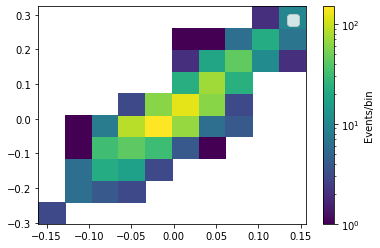

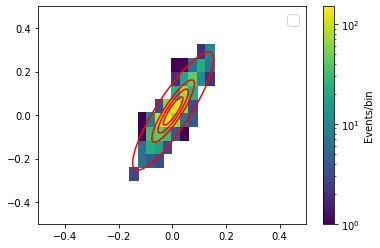

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 307.3                   |    Ncalls=1349 (1349 total)    |
| EDM = 3.17E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
132.18873249083893 -1.1613492525034883e-16 9.549592634120045e-17 2.268970299002756 0.006021781195259738 3.8075221448520944 0.21285326870485008



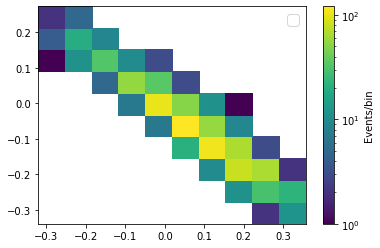

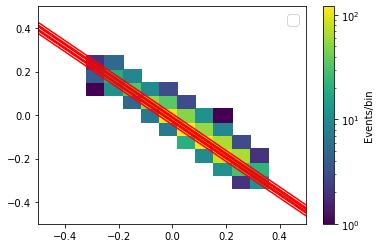

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 56.14                   |    Ncalls=1876 (1876 total)    |
| EDM = 3.99E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
72.92532712943687 4.20568980781365e-18 -5.101160480513819e-19 -0.46658107058313036 0.1054228832645091 -0.028704532355409425 -0.1229748663646826



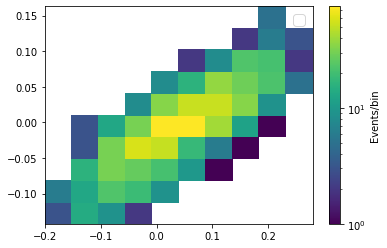

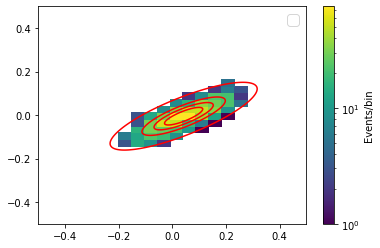

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 524.9                   |    Ncalls=2077 (2077 total)    |
| EDM = 0.000196 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
10.26580671142397 -2.6103409404335682e-17 2.0068199907583897e-16 1.4381632793565218 411.0735153360521 0.013340028184904372 0.2483264550184475



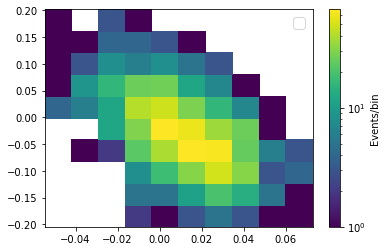

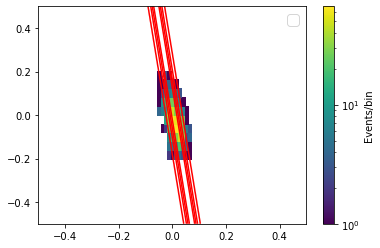

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 465.5                   |    Ncalls=1770 (1781 total)    |
| EDM = 51.4 (Goal: 1E-05)      |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
16.52183309798982 1.668451220958423e-17 -4.052980226767218e-18 0.11186669502858941 0.18733434344769395 0.012160862802730035 0.02830181497051766



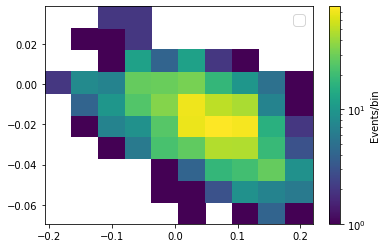

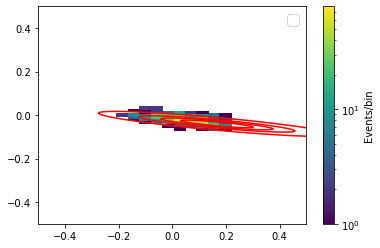

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 35.54                   |    Ncalls=1605 (1605 total)    |
| EDM = 1.92E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
92.0457940247691 1.3961358516427562e-18 -1.3069557774860453e-18 0.46113082500793223 0.016203097173031974 0.06312688497410877 -0.004587035728728544



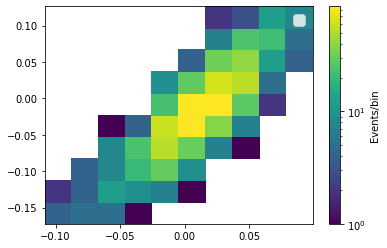

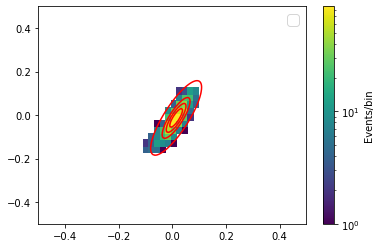

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 212.9                   |    Ncalls=1304 (1304 total)    |
| EDM = 0.000131 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
61.76109942433152 -8.232643508949124e-17 1.374319769476419e-16 1.0275117340552802 1.3842724639762136 0.01741310716651094 -0.03676801120506481



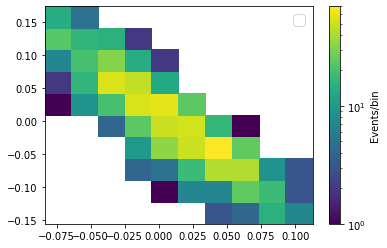

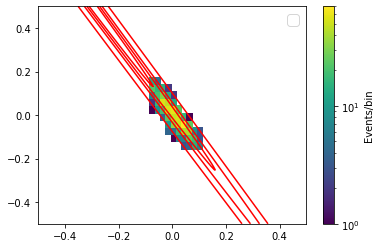

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 586.3                   |     Ncalls=696 (707 total)     |
| EDM = 9.46 (Goal: 1E-05)      |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
16.57108936585275 -1.4073061279768192e-16 -2.3423597360279434e-16 -1.0289148253434333 1.6122849138211055 -0.04807228763590708 0.7407849330340303



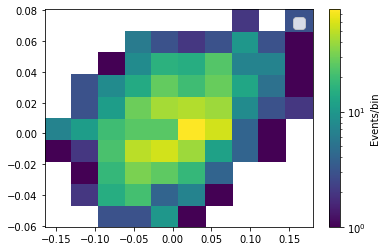

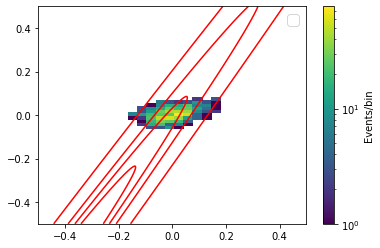

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 577.3                   |    Ncalls=3309 (3309 total)    |
| EDM = 3.94E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
17.28757352142934 -4.361884415016653e-16 -1.5101432463283997e-15 0.28317622118448826 0.014071973745094148 21.569123015401654 0.18402205332273236



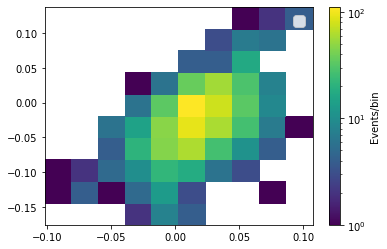

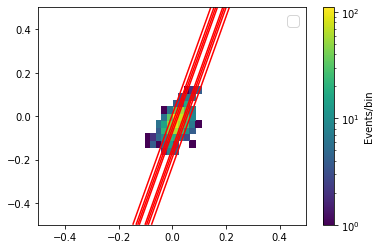

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 710.3                   |    Ncalls=1758 (1758 total)    |
| EDM = 7.67E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
107.38488779235448 9.318378828131478e-16 -6.530043530050895e-16 0.6101957247841754 37.05915333689349 0.8034173015173776 -101.34447794474998



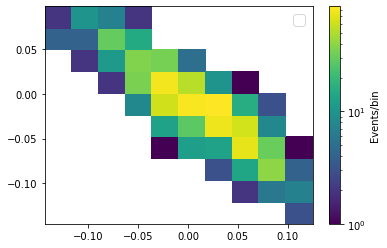

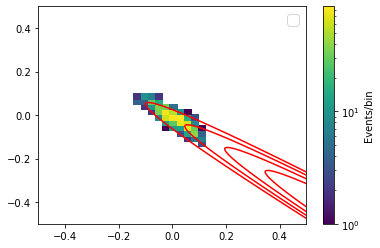

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 521.3                   |     Ncalls=501 (501 total)     |
| EDM = 4.33E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
134.10139510918236 3.007659481430568e-18 1.961031227296002e-16 0.10678434701683749 0.020109854902425617 18.797469588073483 0.34112244753094584



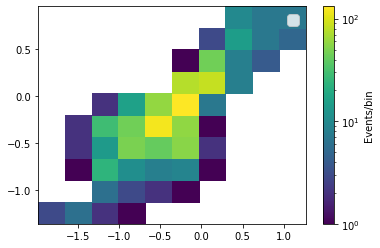

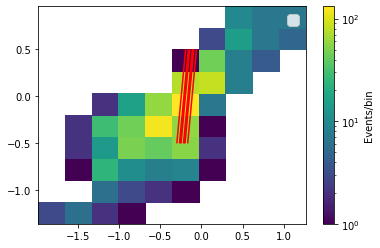

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 569.7                   |    Ncalls=3321 (3321 total)    |
| EDM = 6.93E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
294.9704668915242 8.811083967462826e-17 -1.73919274887262e-15 1.5205064718640886 16.562853652740387 0.3183044126574817 -165.89521720035114



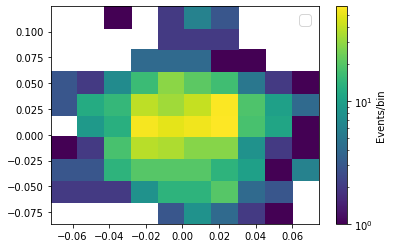

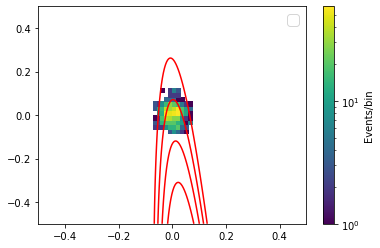

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 237.1                   |    Ncalls=2371 (2371 total)    |
| EDM = 2.41E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
47.18348807677347 -2.1895463720031938e-18 7.198126516790398e-19 0.1826658169294003 0.051838870703566554 0.017759240259465504 -0.04225917312955567



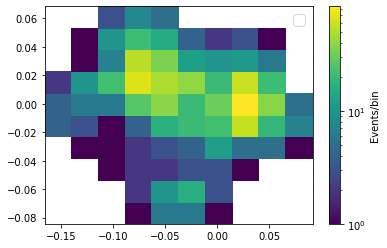

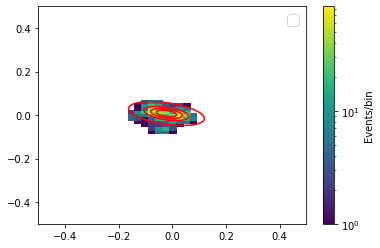

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: UserWarning: No contour levels were found within the data range.


------------------------------------------------------------------
| FCN = 707.2                   |     Ncalls=287 (287 total)     |
| EDM = 0.000121 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
6.062633307727948 -2.811574854979063e-16 -1.2404130427577025e-16 0.8039495814204181 1.1272335495557397 0.4472318858149781 0.6589235430126291



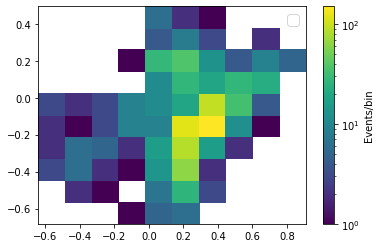

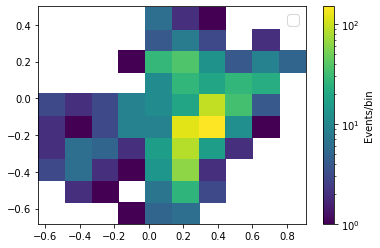

No handles with labels found to put in legend.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter theta is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: InitialParamWarning: Parameter const is floating but does not have initial step size. Assume 1.
No handles with labels found to put in legend.


------------------------------------------------------------------
| FCN = 356.2                   |    Ncalls=1404 (1404 total)    |
| EDM = 4.3E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
18.464539577280117 -6.261110592550131e-17 7.384291221970165e-17 0.8579145284384866 19.516164606548386 0.01851399429016815 0.0456861133071412



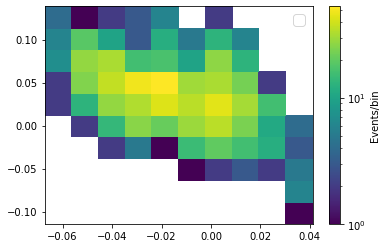

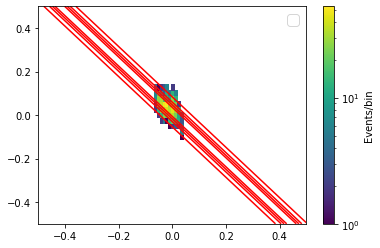

In [46]:
for i in range(0,15):
    scale_factor_for_fit = 1/1e-16
    amp_swap = np.swapaxes(amp,0,1,)*scale_factor_for_fit
    phase_swap = np.swapaxes(phase,0,1)*scale_factor_for_fit
    z, xedges,yedges = np.histogram2d(amp_swap[i],phase_swap[i],bins=(10,10))


    x_bin_center = 0.5*(xedges[1:]+xedges[:-1])
    y_bin_center = 0.5*(yedges[1:]+yedges[:-1])

    x_mesh, y_mesh = np.meshgrid(x_bin_center, y_bin_center)
    x_mesh_ravel = x_mesh.ravel()
    y_mesh_ravel = y_mesh.ravel()

    data_z_ravel = z.ravel()
    z_error = np.sqrt(data_z_ravel)

    plot_bins = 256
    xplot = np.linspace(amp[0],amp[-1],plot_bins)
    yplot= np.linspace(phase[0],phase[-1],plot_bins)

    xplot,yplot = np.meshgrid(xplot,yplot)


    fig, ax = plt.subplots(1, 1)

    plt.pcolormesh(xedges, yedges, z, norm = matplotlib.colors.LogNorm())

    plt.colorbar(label = "Events/bin")
    #plt.xlabel('$cs1$ [pe]')
    #plt.ylabel('$cs2_b/100$ [pe]')


    plt.legend(fancybox=True, fontsize = 15)

    def chisquare_2d(function, data_x, data_y,data_z,data_z_error, functionparams=list):
        chisquarevaluex=np.sum(np.power(np.divide(np.subtract(function(data_x,data_y,functionparams),data_z),data_z_error),2))
        ndf = len(data_y)-len(functionparams)
        #print(ndf)
        return (chisquarevaluex, ndf)

    def chisquare_2d_gaus_xenon(amp,x0,y0,theta,a,b,const):
        return chisquare_2d(function=two_dimensional_gaussian_XENONStyle,functionparams=[amp,x0,y0,theta,a,b,const],data_x=data_x,data_y=data_y,data_z=data_z,data_z_error=data_z_error)[0]

    def chisquare_2d_gaus_Akio(a,b,c,d,e,f):
        return chisquare_2d(function=two_dimensional_gaussian_Akiostyle,functionparams=[a,b,c,d,e,f],data_x=data_x,data_y=data_y,data_z=data_z,data_z_error=data_z_error)[0]


    data_x = x_mesh_ravel
    data_y = y_mesh_ravel
    data_z = data_z_ravel
    data_z_error = np.sqrt(data_z) + 1
    m2=Minuit(chisquare_2d_gaus_xenon,amp=10,fix_amp=False,x0=np.mean(amp)*scale_factor_for_fit,fix_x0=False,y0=np.mean(phase)*scale_factor_for_fit,fix_y0=False,theta=0.1,a=1,b=1,const=0,errordef = 1,print_level=1)
    m2.migrad(ncall=500000)
    print(m2.values["amp"],m2.values["x0"]/scale_factor_for_fit,m2.values["y0"]/scale_factor_for_fit,m2.values["theta"],m2.values["a"],m2.values["b"],m2.values["const"])
    print()
    #plt.title("%s" %i)
    #plt.plot(FreqTF,transfer_function1(data_x,params=[m2.values["a"],m2.values["b"],m2.values["c"],m2.values["d"]]))
    #plt.plot(FreqTF,TF[i][i])
    #plt.yscale("log")
    #plt.show()

    arg_list = [m2.values["amp"],m2.values["x0"],m2.values["y0"],m2.values["theta"],m2.values["a"],m2.values["b"],m2.values["const"]]

    plot_bins = 256
    xplot = np.linspace(-0.5,0.5,plot_bins)
    yplot= np.linspace(-0.5,0.5,plot_bins)

    xplot,yplot = np.meshgrid(xplot,yplot)

    fig, ax = plt.subplots(1, 1)

    plt.pcolormesh(xedges, yedges, z, norm = matplotlib.colors.LogNorm(), cmap="viridis")
    plt.colorbar(label = "Events/bin")
    plt.legend(fancybox=True, fontsize = 15)

    lines = np.linspace(1, np.max(two_dimensional_gaussian_XENONStyle(xplot, yplot, arg_list)),5)

    ax.contour(xplot, yplot, two_dimensional_gaussian_XENONStyle(xplot, yplot, arg_list), lines, colors='r', label="Fit")
    plt.show()